In [1]:
from models import regression_model
import data_preprocessing
from conformal_prediction import EnCQR
import utils
import data_loaders

2023-03-26 13:54:22.665543: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:54:22.752908: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:54:22.754633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 13:54:23.871338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


First, we specify several configuration hyperparameters and we store them in a dictionary.
Not all of them are used at the same time. For example, if we decide to use an LSTM model, the parameters that specifies the TCN and RF model are not used. 

In [2]:
# General hyperparams
B = 1                       # number of ensembles
alpha = 0.1                 # confidence level            
quantiles = [alpha/2,       # quantiles to predict
             0.5,
             1-(alpha/2)] 

# rf hyperparams
n_trees = 20                # number of trees in each rf model

# lstm tcn only
regression = 'quantile'     # options: {'quantile', 'linear'}. If 'linear', just set one quantile
l2_lambda = 1e-4            # weight of l2 regularization in the lstm and tcn models
batch_size = 16             # size of batches using to train the lstm and tcn models

# lstm hyperparams
units = 128                 # number of units in each lstm layer
n_layers = 3                # number of lstm layers in the model

# tcn hyperparams
dilations = [1,2,4,8]       # dilation rate of the Conv1D layers
n_filters = 128             # filters in each Conv1D layer 
kernel_size = 7             # kernel size in each ConvID layer

# Store the configuration in a dictionary
P = {'B':B, 'alpha':alpha, 'quantiles':quantiles,
     'n_trees':n_trees,  
     'regression':regression,'l2':l2_lambda, 'batch_size':batch_size,
     'units':units,'n_layers':n_layers,
     'dilations':dilations, 'n_filters':n_filters, 'kernel_size':kernel_size}

### Data loading
For this example, we will use 3 years of data relative to solar power production.
We will use the first year for training, the second for validation, and the last year as test set.

*Note:* To use your own data, you must write a data loader which returns a single DataFrame or, like in this case, 3 DataFrames (one for training, one for validation, and one for test). You can find two examples of data loaders in [data_loaders.py](https://github.com/FilippoMB/Ensemble-Conformalized-Quantile-Regression/blob/main/data_loaders.py).

In [3]:
df = data_loaders.get_gas_data()
df.head()

,Price
0,18.47
1,18.79
2,18.61
3,18.67
4,18.64


In [4]:
train_df, val_df, test_df = data_loaders.get_solar_data()
train_df.head()

/home/maddin/Dokumente/Ensemble-Conformalized-Quantile-Regression/data_loaders.py:58: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  date_list = pd.date_range(start='01/01/2017', end='31/07/2020')


                     MWH  Temperature_F  Humidity_percent  Sunhour  \
hour_list                                                            
2017-01-01 00:00:00  0.0             58                95      8.7   
2017-01-01 01:00:00  0.0             57                95      8.7   
2017-01-01 02:00:00  0.0             56                95      8.7   
2017-01-01 03:00:00  0.0             56                95      8.7   
2017-01-01 04:00:00  0.0             55                89      8.7   
...                  ...            ...               ...      ...   
2017-12-31 19:00:00  0.0             32                67      3.8   
2017-12-31 20:00:00  0.0             31                65      3.8   
2017-12-31 21:00:00  0.0             30                63      3.8   
2017-12-31 22:00:00  0.0             29                61      3.8   
2017-12-31 23:00:00  0.0             29                58      3.8   

                     CloudCover_percent  uvIndex  
hour_list                             

,MWH,Temperature_F,Humidity_percent,Sunhour,CloudCover_percent,uvIndex
hour_list,,,,,,
2017-01-01 00:00:00,0.0,58,95,8.7,11,1
2017-01-01 01:00:00,0.0,57,95,8.7,11,1
2017-01-01 02:00:00,0.0,56,95,8.7,11,1
2017-01-01 03:00:00,0.0,56,95,8.7,12,1
2017-01-01 04:00:00,0.0,55,89,8.7,13,1


### Data preprocessing

The ``data_windowing()`` function transforms each DataFrame into 3-dimensional arrays of shape \[*number of samples*, *time steps*, *number of variables* \].
The input data, X, might have a different number of time steps and a different number of variables than the output data, Y. In this case, we want to predict the energy production for the next day given the measurements of the past week. 
Therefore, the second dimension of X is ``time_steps_in=168`` (hours in the past week) and the second dimension of Y is ``time_steps_out=24`` (hours of the next day). The input variables are the historical energy production plus 5 exogenous variables, so the last dimension of X is ``n_vars=6``. Since we want to predict the future energy production, we specify the target variable to predict: ``label_columns=['MWH']``. Note that in Y ``n_vars=1``.

``data_windowing()`` also rescales each variable in \[0,1\] and return the scaler, which is used to invert the transformation.

In addition, it also splits training data in *B* disjoint sets, used to train the ensemble model. In this case, ``B=3``.

![data_shape.drawio.png](attachment:data_shape.drawio.png)

In [5]:
train_data, val_x, val_y, test_x, test_y, Scaler = data_preprocessing.data_windowing(df=train_df, 
                                                                                     val_data=val_df,
                                                                                     test_data=test_df,
                                                                                     B=1, 
                                                                                     time_steps_in=168, 
                                                                                     time_steps_out=24, 
                                                                                     label_columns=['MWH'])

print("-- Training data --")
for i in range(len(train_data)):
    print(f"Set {i} - x: {train_data[i][0].shape}, y: {train_data[i][1].shape}")
print("-- Validation data --")
print(f"x: {val_x.shape}, y: {val_y.shape}")
print("-- Test data --")
print(f"x: {test_x.shape}, y: {test_y.shape}")

# Update configuration dict
P['time_steps_in'] = test_x.shape[1]
P['n_vars'] = test_x.shape[2] 
P['time_steps_out'] = test_y.shape[1]

-- Training data --
Set 0 - x: (350, 168, 6), y: (350, 24)
-- Validation data --
x: (357, 168, 6), y: (357, 24)
-- Test data --
x: (357, 168, 6), y: (357, 24)


### Training the quantile regression models

Before looking into the conformalization of the PI, let's see how we can train different models that perform quantile regression.

In the paper we considered three models:
- a random forest (rf)
- a recurrent neural network with LSTM cells
- a feedforward neural network with 1-dimensional convolutional cells (TCN).

In principle, any other model performing quantile regression can be used. Each model must implement a ``fit()`` function with is used to train the model parameters and a ``transform()`` function used to predict new data.
The ``fit()`` function uses ``val_x`` and ``val_y`` to perform early stopping.

Let's start with the **TCN** model.

2023-03-26 14:08:33.321617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [350,24]
	 [[{{node Placeholder/_1}}]]
2023-03-26 14:08:45.406174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [357,24]
	 [[{{node Placeholder/_1}}]]


<Figure size 640x480 with 0 Axes>

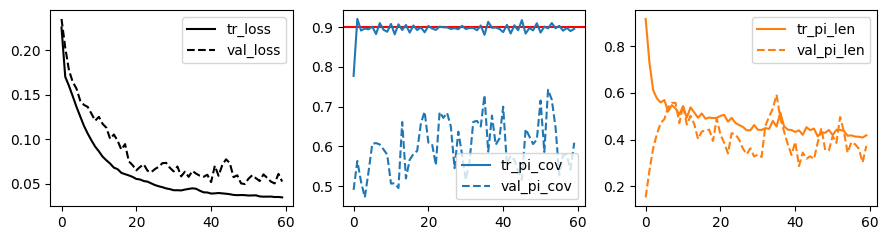

2023-03-26 14:14:51.683735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [357,168,6]
	 [[{{node Placeholder/_0}}]]


[[[ 0.00137784  0.00639997  0.04187622]
  [ 0.00136629  0.02425129 -0.06444925]
  [-0.01042559 -0.068408    0.09408544]
  ...
  [-0.02759496  0.02776548  0.05942546]
  [-0.11758989  0.01868953  0.12220078]
  [ 0.04134611  0.02152929  0.04099266]]

 [[ 0.00204775  0.01444113  0.04579886]
  [ 0.00486665  0.01611819 -0.06180463]
  [-0.02257684 -0.07613862  0.06435111]
  ...
  [-0.01591252  0.04718984  0.01870753]
  [-0.09026407  0.00795144  0.11554249]
  [ 0.03322884 -0.00304003  0.0034187 ]]

 [[-0.02488555  0.02151887  0.05161249]
  [ 0.00574692  0.02742705 -0.06785456]
  [-0.02550213 -0.07173944  0.06882139]
  ...
  [-0.03683919  0.04254858  0.02329752]
  [-0.10096363 -0.00487481  0.11108152]
  [ 0.02428269 -0.01650755  0.00324976]]

 ...

 [[-0.02974347  0.01487978  0.04846044]
  [-0.00785749  0.03502353 -0.06651672]
  [-0.02188184 -0.07281228  0.09067802]
  ...
  [-0.04242333  0.03637442  0.03624037]
  [-0.12260964 -0.004363    0.12109537]
  [ 0.03803623 -0.01816506  0.01252089]]

 [

<Figure size 640x480 with 0 Axes>

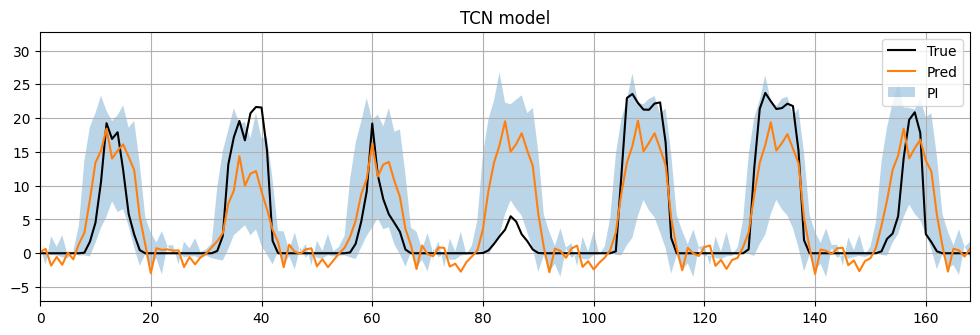

In [8]:
P['model_type'] = 'tcn' 

# Train 
model = regression_model(P)
hist = model.fit(train_data[0][0], train_data[0][1], val_x, val_y)
utils.plot_history(hist)

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='TCN model')

The function ``plot_hist()`` plots how the loss, coverage, and PI length evolve during training on the train and validation set.
Note that here we trained the model only on the first subset of the training set.

Next we train the **LSTM** model. To do that, we just change ``model_type`` in the hyperparameters dictionary.

In [7]:
P['model_type'] = 'lstm'

# Train
model = regression_model(P)
hist = model.fit(train_data[0][0], train_data[0][1], val_x, val_y)
utils.plot_history(hist)

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='LSTM model')

2023-03-26 14:00:09.272936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-26 14:00:09.275156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-26 14:00:09.276707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyboardInterrupt: 

Finally, we train the **RF** model. As before, we change  ``model_type`` in the hyperparameters dictionary. Contrairly to the previous two neural network model, the ``fit()`` function does not use ``val_x`` and ``val_y`` since there is no early stopping.

In [ ]:
# Train
P['model_type'] = 'rf'
model = regression_model(P)
model.fit(train_data[0][0], train_data[0][1])

# Test
PI = model.transform(test_x)
utils.plot_PIs(test_y, PI[:,:,1],
                PI[:,:,0], PI[:,:,2],
                x_lims=[0,168], scaler=Scaler, title='RF model')

### EnCQR

Finally, we compute the intervals with the EnCQR method.

This is done by calling the function ``EnCQR()``, which returns two intervals:
- the PI computed by the ensemble of QR models
- the conformalized PI

In this example, we consider an ensemble of TCN models and show that after conformalization the coverage of the PI gets much closer to the desired confidence level.

In [ ]:
P['model_type'] = 'tcn'

# compute the conformalized PI with EnCQR
PI, conf_PI = EnCQR(train_data, val_x, val_y, test_x, test_y, P)

# Plot original and conformalized PI
utils.plot_PIs(test_y, PI[:,:,1],
               PI[:,:,0], PI[:,:,2],
               conf_PI[:,:,0], conf_PI[:,:,2],
               x_lims=[0,168], scaler=Scaler, title='EnCQR')

# Compute PI coverage and length before and after conformalization
print("Before conformalization:")
utils.compute_coverage_len(test_y.flatten(), PI[:,:,0].flatten(), PI[:,:,2].flatten(), verbose=True)
print("After conformalization:")
utils.compute_coverage_len(test_y.flatten(), conf_PI[:,:,0].flatten(), conf_PI[:,:,2].flatten(), verbose=True)